# Leak Location Optimization
### Import Necessary Libraries

In [15]:
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
import pygad
import numpy
import glob
import wntr
import os

In [16]:
plt.rcParams['figure.figsize'] = (12,8)

In [17]:
import warnings
warnings.filterwarnings('ignore')

In [26]:
class Config:
    num_generations =100 #Number of generations.
    num_parents_mating = 1 # Number of solutions to be selected as parents in the mating pool.
    sol_per_pop = 20 # Number of solutions in the population.
    num_genes = 1 #len(function_inputs) --> this can be an array
    init_range_low = 0
    init_range_high = 1
    parent_selection_type = "sss" # Type of parent selection.
    keep_parents = -1 # Number of parents to keep in the next population. -1 means keep all parents and 0 means keep nothing.
    crossover_type = "single_point" # Type of the crossover operator. 
    mutation_type = "random" # Type of the mutation operator.
    mutation_num_genes=1 # Type of the mutation operator.
    last_fitness = 0
    
    INP_FILE_PATH = r"../data/Real_Synthetic_Net.inp" 
    TEMP_DIR = "../temp/"
    PLOTS_DIR = "../plots"
    FUNCTION_INPUTS = None
    DESIRED_OUTPUT = None

In [121]:
class WaterLeakModel(Config):
    
    def __init__(self, node:str):
        ''' 
            node: node/junction ID in the network
        '''
        
        # Check if node is junction_name 
        wn = wntr.network.WaterNetworkModel(self.INP_FILE_PATH)
        assert wn.junction_name_list.count(node) == 1, "Node not found in the network"
        self.node_index = wn.junction_name_list.index(node)
        
        self.node = node
        
    
    def simulate(self, wn, plot_graph=True):
        """
        If plot_graph is set to true, a graph of the network is plotted after simulation
        """
        # Plot pressure after add leak to node
            
        sim = wntr.sim.WNTRSimulator(wn)
        results = sim.run_sim()
        pressure = results.node['pressure']
        pressure_at_N6 = pressure.loc[:,wn.junction_name_list[self.node_index]]
        if plot_graph:
            wntr.graphics.plot_network(wn, node_attribute=pressure.any(), node_size=150, title='Pressure at 0 hours')
        
        return results
    
    def change_discharge_coefficient(self, wn, emitter_value):
        """
        This function changes the emitter coefficient for selected node in the network, and create a 
        structured representation of our data, a csv.
        
        parameters
        ----------
        wn: wntr network object
        emitter_value: the emitter coefficient value
        """
        
        # Change emitter coefficient
        node = wn.get_node(str(self.node))
        node.add_leak(wn, area=0.00015, start_time=0, end_time=1, discharge_coeff=emitter_value)
        return self.simulate(wn, plot_graph=False)
    
    def export_results(self, solutions:list, path:str, name:str):
        """
        Concatenates all solutions generated and exports as a single csv file
        
        parameters
        ----------
        solution: a list of all paths to the solutions csv files
        path: path where concatenated solution will be exported to
        name: name to be assigned to exported file
        """
        if not os.path.exists(path):
            os.mkdir(path)
        
        temp = pd.DataFrame()
        for i in range(len(solutions)):
            data = pd.read_csv(solutions[i])
            if i == 0:
                temp = data
            else:
                temp = pd.concat([temp, data])
        name+=".csv"
        try:
            temp.to_csv(os.path.join(path,name),index=False)
            print(f'File Exported Successfully to path: {os.path.join(path, name)}')
        except Exception as e:
            print(e)
            
    def run(self, leak_area=0.00015, start_time=0, end_time=1, discharge_coeff=.5, function_inputs=0.5, plot_graph=True):
        """
        Adds a leak to node passed to WaterLeakModel() object and simulates
        
        parameters
        ----------
        leak_area: area of the leak
        start_time: time in seconds to start the leak
        end_time: time in seconds to end the leak
        discharge_coeff: Leak discharge coefficient; Takes on values between 0 and 1.
        function_inputs = inputs for optimization, can be array of numbers
        plot_graph: If plot_graph is set to true, a graph of the network is plotted after simulation
        """
        # Add leak and simulate
        wn = wntr.network.WaterNetworkModel(self.INP_FILE_PATH)
        node = wn.get_node(self.node)
        node.add_leak(wn, area=leak_area, start_time=start_time, end_time=end_time, discharge_coeff=.5)
        self.simulate(wn, plot_graph=plot_graph)

        self.FUNCTION_INPUTS = function_inputs
        self.DESIRED_OUTPUT = node.head - node.elevation
        
    def validate_leak_result(self, junction_id, emitter_coeff=0.5, description='Leak location'):
        """
        Detects leak location
        
        parameters
        ----------
        junction_id: the node in the network
        emitter_coeff: any assumed value of leak size
        description: the title for the plot
        """
        # keep emitter_coeff within the range of 0-1
        if emitter_coeff > 1:
            emitter_coeff = emitter_coeff%1
            
        wn = wntr.network.WaterNetworkModel(self.INP_FILE_PATH)
        node = wn.get_node(junction_id)
        #simulate the network after getting the node
        self.simulate(wn, plot_graph=False)
        
        desired_output = node.head - node.elevation
        all_nodes = wn.junction_name_list
        
        data=pd.DataFrame(columns=['NODE','EMITTER_COEFFICIENT','PRESSURE_OUTPUT','FITNESS']) 
        
        for i in range(len(all_nodes)):
            wn = wntr.network.WaterNetworkModel(self.INP_FILE_PATH)
            self.node = wn.junction_name_list[i]
#             if self.node == junction_id:
#                 emitter_coeff = emitter_coeff
#             else:
#                 emitter_coeff = 0
            results = self.change_discharge_coefficient(wn, emitter_value=emitter_coeff)
            pressure = results.node['pressure']
            pressure_output = pressure.loc[:,self.node]
            fitness = 1.0 / (np.abs(pressure_output - desired_output) + 0.000001)

            data=data.append({'NODE':all_nodes[i],'EMITTER_COEFFICIENT':emitter_coeff,'PRESSURE_OUTPUT':list(pressure_output)[0],'FITNESS':list(fitness)[0]},ignore_index=True)
            data=data.sort_values(by='FITNESS',ascending=False)
            data=data.reset_index(drop=True)
            
            plt.figure(figsize=(10,5))
            plt.plot(data['NODE'],data['FITNESS'])

            plt.xlabel('NODE ',fontsize=14)
            plt.ylabel('FITNESS',fontsize=14)

            plt.title(description,fontsize=16)
#             plt.savefig(f"{self.PLOTS_DIR}/leak_location_validation_{node}_.png")
        return data

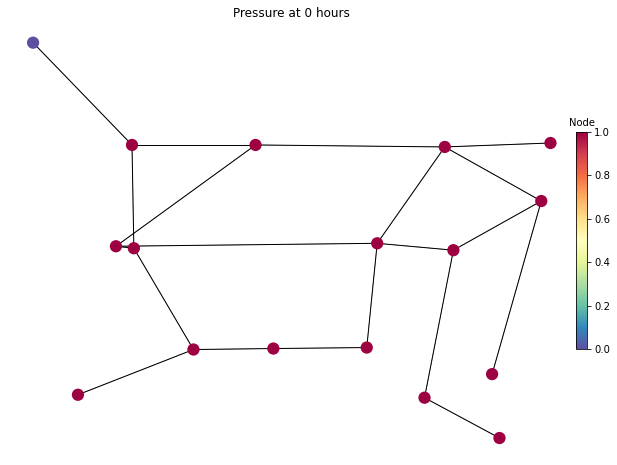

In [122]:
# Instantiate the pygad optimization class
water_model = WaterLeakModel(node='N6')
water_model.run()

> **The node with the highest fitness is considered to have a leak.**

In [123]:
pressure

,N1,N5,N10,N7,N2,N6,N3,N8,N13,N9,N14,N4,N11,N12,N15,N16,Reservior
0,9.343952,23.983298,28.929754,27.015035,24.820801,26.545978,26.998864,24.95954,30.395603,24.192659,24.881406,28.914152,27.801691,24.388567,28.925708,26.997845,0.0


## Add Leak in a Random Node 

This is to validate that our model can detect leak in another 

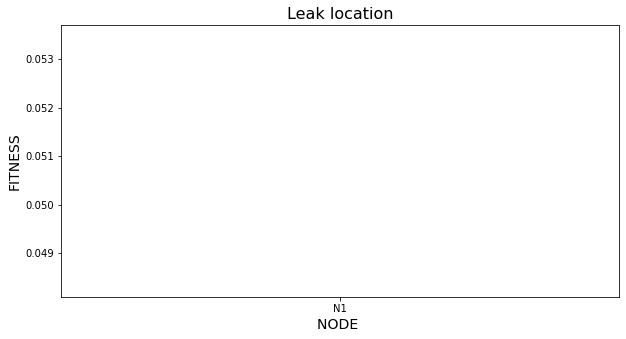

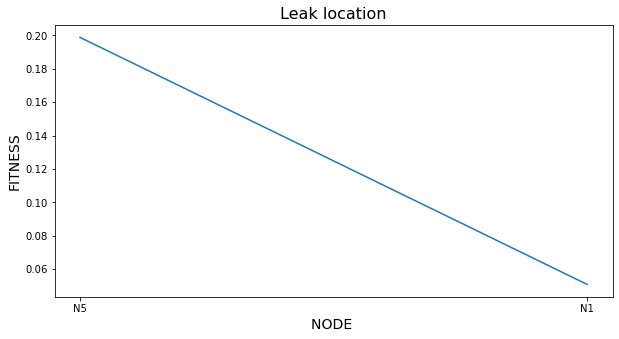

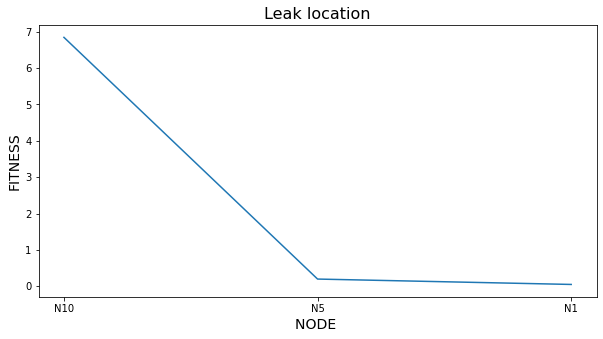

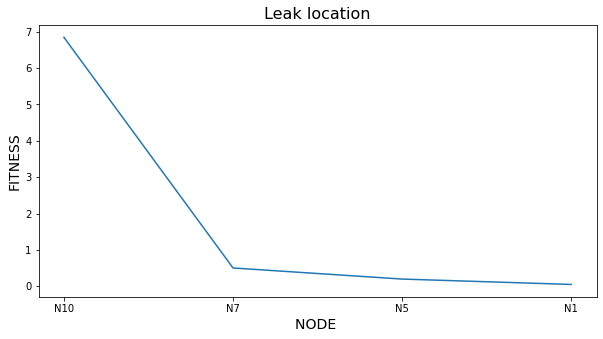

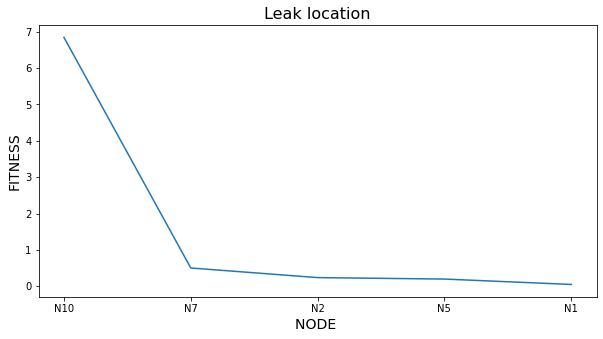

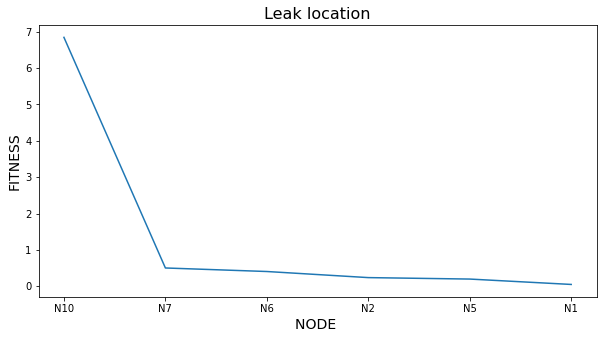

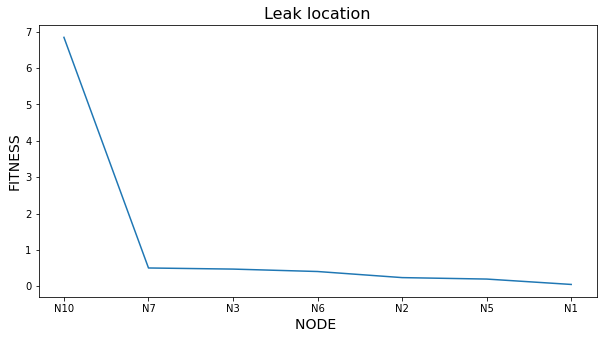

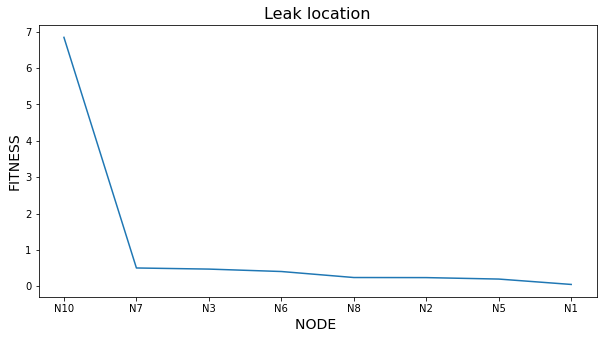

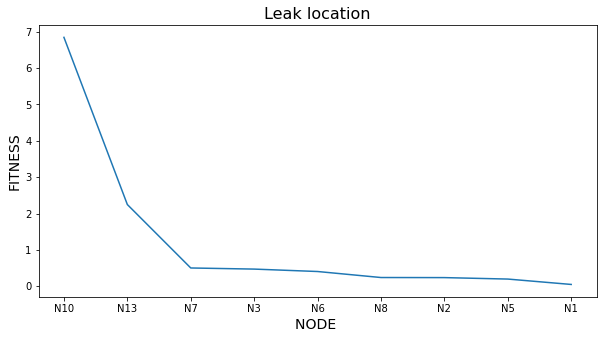

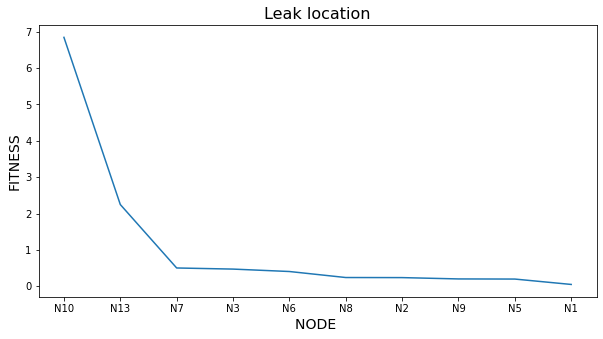

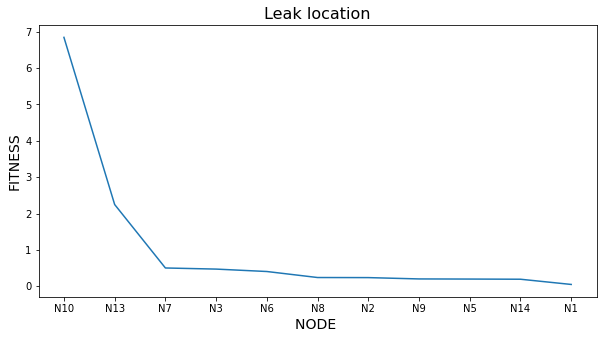

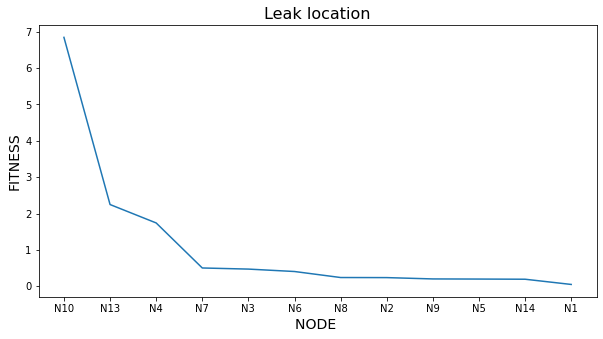

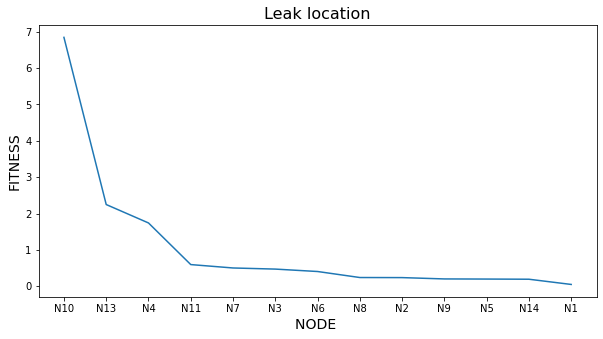

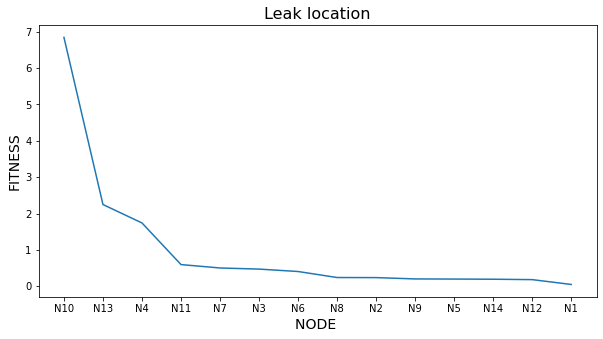

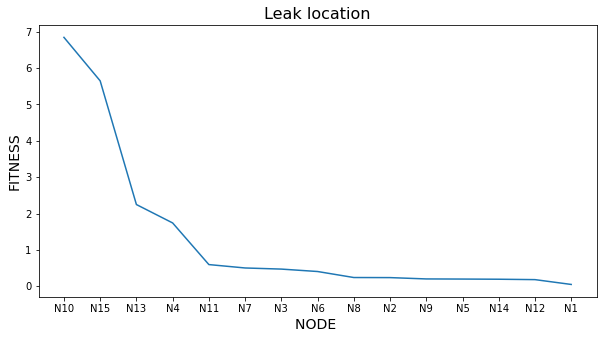

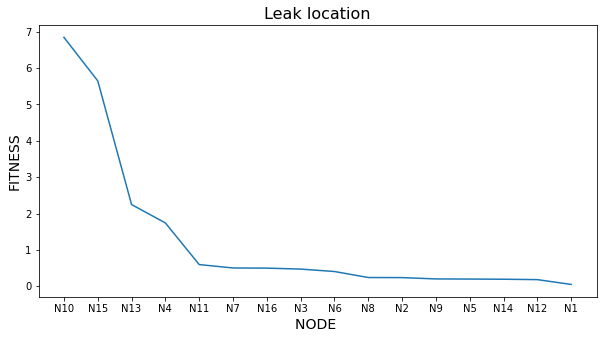

In [124]:
data = water_model.validate_leak_result('N4')

In [108]:
data

,NODE,EMITTER_COEFFICIENT,PRESSURE_OUTPUT,FITNESS
0,N6,0,26.617940,8.478837
1,N3,0,27.085028,1.709316
2,N16,0,27.253194,1.327677
3,N7,0,27.256189,1.322419
4,N8,0,25.159246,0.745848
5,N11,0,27.842038,0.745135
6,N14,0,25.061021,0.694937
7,N2,0,24.870362,0.613633
8,N12,0,24.588272,0.523087
9,N9,0,24.372273,0.469985


0